In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [ ]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

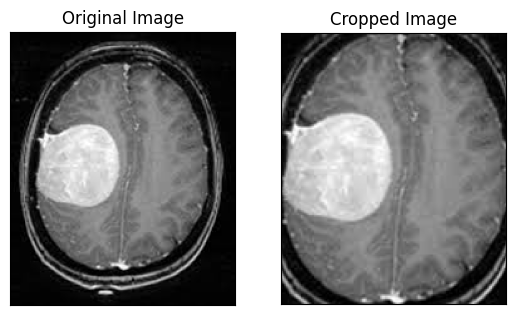

In [5]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
augmented_path = 'C:\\Users\\mohan\\Downloads\\Brain-Tumor-detection-using-Digital-image-processing-main\\brain_tumor_dataset'

augmented_yes = augmented_path + '\\yes'  
augmented_no = augmented_path + '\\no'    

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [ ]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1     
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

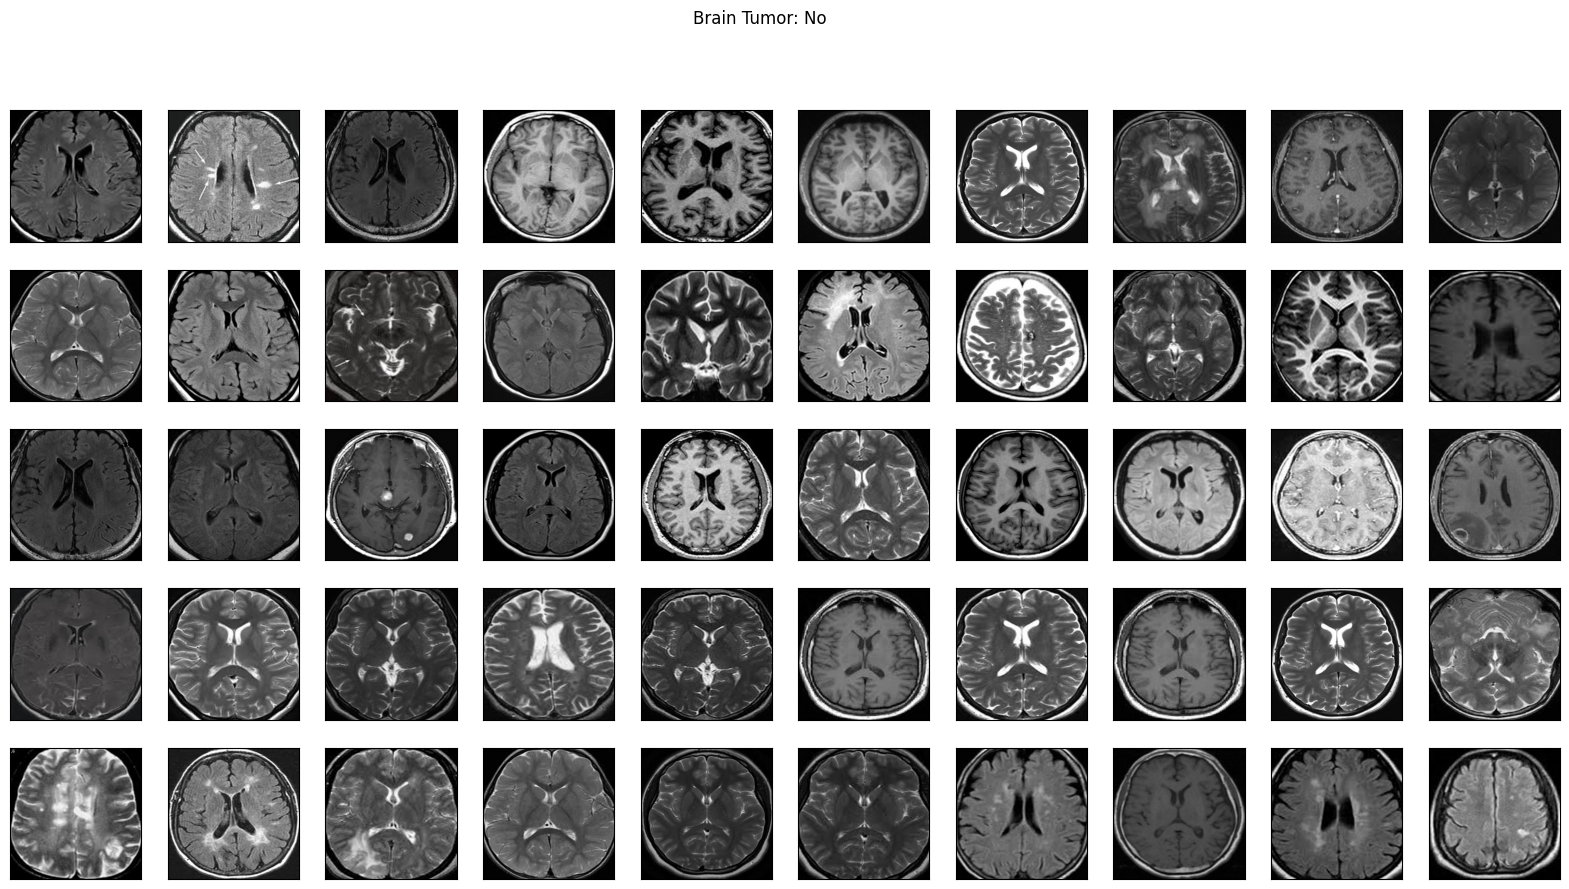

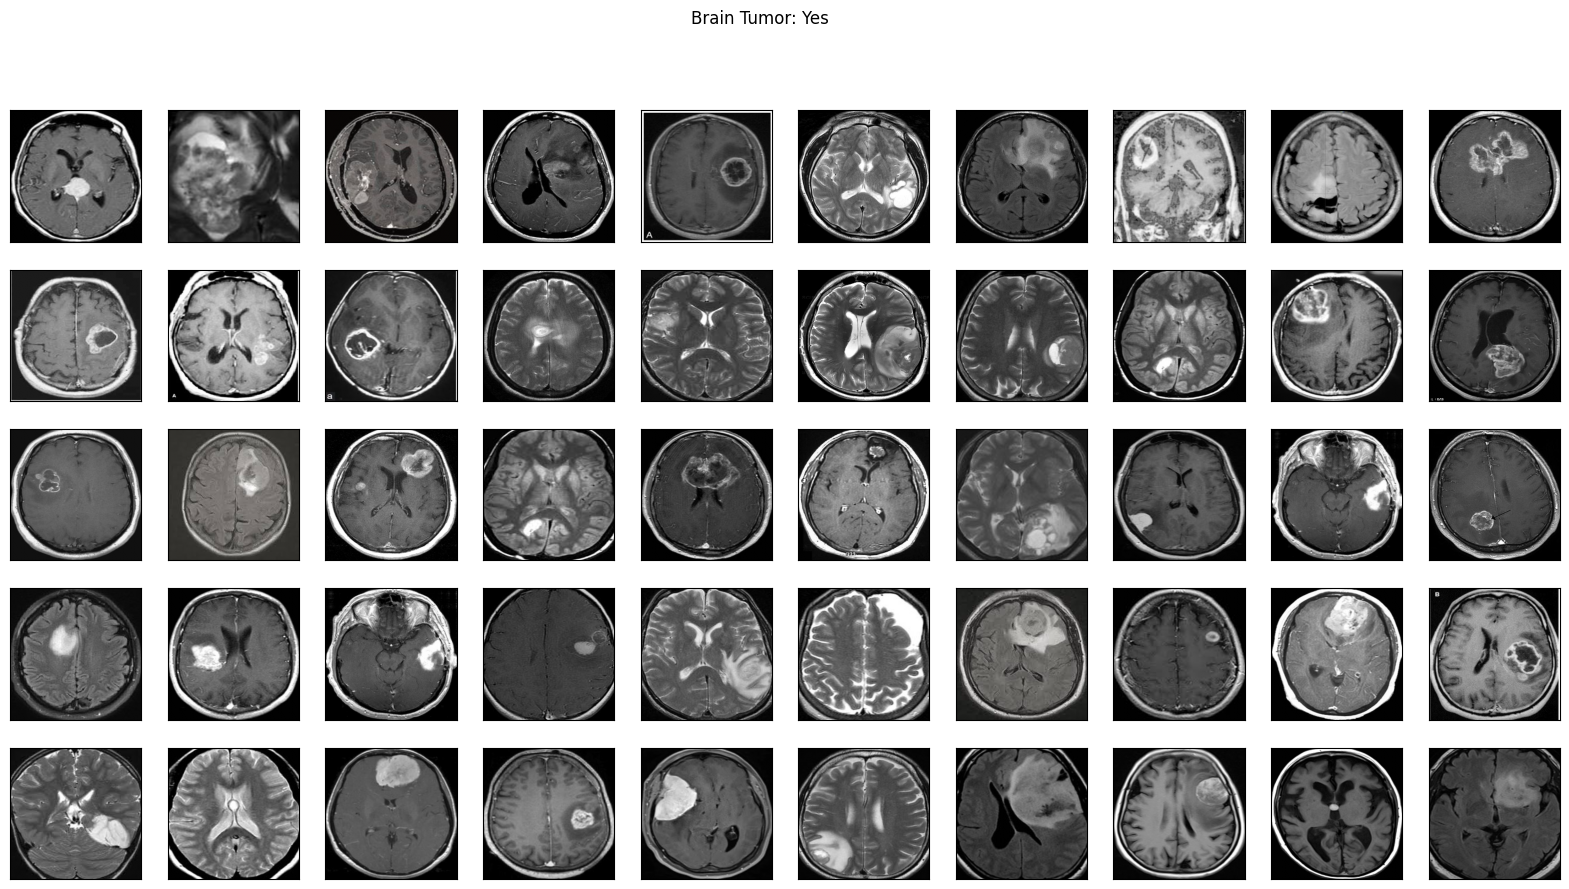

In [14]:
plot_sample_images(X, y)

In [ ]:
def split_data(X, y, test_size=0.2):
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [17]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 240, 240, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 240, 240, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 240, 240, 3)
Y_test shape: (38, 1)


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [ ]:
def build_model(input_shape):

    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [21]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [22]:
model = build_model(IMG_SHAPE)

In [23]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [ ]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 1.7642 - accuracy: 0.5198

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets


6/6 [==============================] - 6s 894ms/step - loss: 1.7642 - accuracy: 0.5198 - val_loss: 0.6824 - val_accuracy: 0.6316
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.5480

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


6/6 [==============================] - 5s 778ms/step - loss: 0.9915 - accuracy: 0.5480 - val_loss: 0.6636 - val_accuracy: 0.6316
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.7941 - accuracy: 0.6667

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.63.model\assets


6/6 [==============================] - 5s 779ms/step - loss: 0.7941 - accuracy: 0.6667 - val_loss: 0.6390 - val_accuracy: 0.6316
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.6554

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.61.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.61.model\assets


6/6 [==============================] - 5s 787ms/step - loss: 0.6822 - accuracy: 0.6554 - val_loss: 0.6198 - val_accuracy: 0.6053
Epoch 5/10
6/6 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.7514

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.63.model\assets


6/6 [==============================] - 5s 817ms/step - loss: 0.5108 - accuracy: 0.7514 - val_loss: 0.6256 - val_accuracy: 0.6316
Epoch 6/10
6/6 [==============================] - ETA: 0s - loss: 0.4369 - accuracy: 0.7571

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.61.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.61.model\assets


6/6 [==============================] - 5s 776ms/step - loss: 0.4369 - accuracy: 0.7571 - val_loss: 0.6210 - val_accuracy: 0.6053
Epoch 7/10
6/6 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8757

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.61.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.61.model\assets


6/6 [==============================] - 5s 799ms/step - loss: 0.3751 - accuracy: 0.8757 - val_loss: 0.6069 - val_accuracy: 0.6053
Epoch 8/10
6/6 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.8531

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.63.model\assets


6/6 [==============================] - 5s 765ms/step - loss: 0.3619 - accuracy: 0.8531 - val_loss: 0.6010 - val_accuracy: 0.6316
Epoch 9/10
6/6 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8701

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.63.model\assets


6/6 [==============================] - 5s 795ms/step - loss: 0.3073 - accuracy: 0.8701 - val_loss: 0.5878 - val_accuracy: 0.6316
Epoch 10/10
6/6 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8814

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.71.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.71.model\assets


6/6 [==============================] - 5s 878ms/step - loss: 0.2777 - accuracy: 0.8814 - val_loss: 0.5883 - val_accuracy: 0.7105
Elapsed time: 0:0:48.7


In [28]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9266

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.66.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.66.model\assets


6/6 [==============================] - 5s 809ms/step - loss: 0.2444 - accuracy: 0.9266 - val_loss: 0.5872 - val_accuracy: 0.6579
Epoch 2/3
6/6 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.8983

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.61.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.61.model\assets


6/6 [==============================] - 5s 837ms/step - loss: 0.2738 - accuracy: 0.8983 - val_loss: 0.5922 - val_accuracy: 0.6053
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.8701

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.76.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.76.model\assets


6/6 [==============================] - 5s 844ms/step - loss: 0.2799 - accuracy: 0.8701 - val_loss: 0.5937 - val_accuracy: 0.7632
Elapsed time: 0:0:14.8


In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8814

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.66.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.66.model\assets


6/6 [==============================] - 5s 823ms/step - loss: 0.2963 - accuracy: 0.8814 - val_loss: 0.5753 - val_accuracy: 0.6579
Epoch 2/3
6/6 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9492

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


6/6 [==============================] - 5s 813ms/step - loss: 0.1975 - accuracy: 0.9492 - val_loss: 0.5736 - val_accuracy: 0.6316
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9492

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.63.model\assets


6/6 [==============================] - 5s 812ms/step - loss: 0.1717 - accuracy: 0.9492 - val_loss: 0.5719 - val_accuracy: 0.6316
Elapsed time: 0:0:14.7


In [30]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9661

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.61.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.61.model\assets


6/6 [==============================] - 5s 824ms/step - loss: 0.1609 - accuracy: 0.9661 - val_loss: 0.5776 - val_accuracy: 0.6053
Epoch 2/3
6/6 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9661

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


6/6 [==============================] - 5s 791ms/step - loss: 0.1548 - accuracy: 0.9661 - val_loss: 0.5646 - val_accuracy: 0.6316
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9718

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.63.model\assets


6/6 [==============================] - 5s 830ms/step - loss: 0.1442 - accuracy: 0.9718 - val_loss: 0.5624 - val_accuracy: 0.6316
Elapsed time: 0:0:14.5


In [32]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9887

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets


6/6 [==============================] - 5s 862ms/step - loss: 0.0971 - accuracy: 0.9887 - val_loss: 0.5592 - val_accuracy: 0.6316
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9944

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


6/6 [==============================] - 5s 806ms/step - loss: 0.0924 - accuracy: 0.9944 - val_loss: 0.5533 - val_accuracy: 0.6316
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9944

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.61.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.61.model\assets


6/6 [==============================] - 5s 819ms/step - loss: 0.0905 - accuracy: 0.9944 - val_loss: 0.5635 - val_accuracy: 0.6053
Epoch 4/5
6/6 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9944

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.66.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.66.model\assets


6/6 [==============================] - 5s 825ms/step - loss: 0.0855 - accuracy: 0.9944 - val_loss: 0.5514 - val_accuracy: 0.6579
Epoch 5/5
6/6 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9944

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.63.model\assets


6/6 [==============================] - 5s 790ms/step - loss: 0.0765 - accuracy: 0.9944 - val_loss: 0.5591 - val_accuracy: 0.6316
Elapsed time: 0:0:24.5


In [33]:
model.save('saved_model/project_model')
history = model.history.history

INFO:tensorflow:Assets written to: saved_model/project_model\assets


INFO:tensorflow:Assets written to: saved_model/project_model\assets


In [34]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [35]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

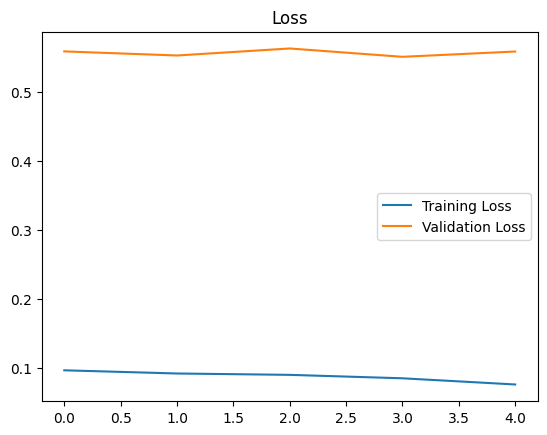

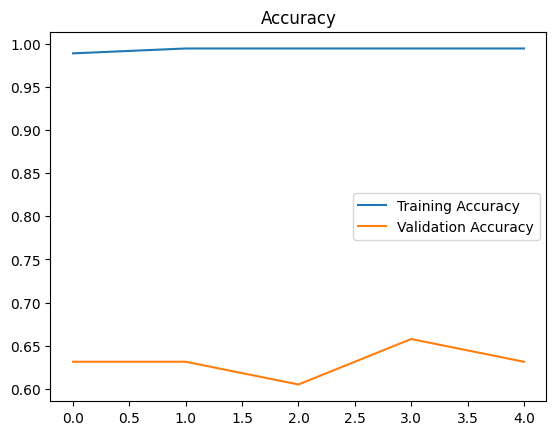

In [36]:
plot_metrics(history) 

In [40]:
import glob
import os
model_files = glob.glob('models/cnn-parameters-improvement-*.model')
latest_model = max(model_files, key=os.path.getctime)

best_model = load_model(latest_model)

In [41]:
best_model.metrics_names

['loss', 'accuracy']

In [42]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 0s 34ms/step - loss: 0.5443 - accuracy: 0.6842


In [43]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.544334888458252
Test Accuracy = 0.6842105388641357


In [44]:
y_test_prob = best_model.predict(X_test)

2/2 [==============================] - 0s 34ms/step


In [45]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.7777777777777778


In [46]:
y_val_prob = best_model.predict(X_val)

2/2 [==============================] - 0s 27ms/step


In [47]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.7636363636363636


In [48]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 


In [ ]:
data_percentage(y)

Number of examples: 253
Percentage of positive examples: 61.26482213438735%, number of pos examples: 155
Percentage of negative examples: 38.73517786561265%, number of neg examples: 98


In [50]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 177
Percentage of positive examples: 62.14689265536723%, number of pos examples: 110
Percentage of negative examples: 37.85310734463277%, number of neg examples: 67
Validation Data:
Number of examples: 38
Percentage of positive examples: 63.1578947368421%, number of pos examples: 24
Percentage of negative examples: 36.8421052631579%, number of neg examples: 14
Testing Data:
Number of examples: 38
Percentage of positive examples: 55.26315789473684%, number of pos examples: 21
Percentage of negative examples: 44.73684210526316%, number of neg examples: 17
